In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

### Personal logs : 
### 256, pas augment, 15% dataset, res18, 5 epoch ==> 0.76 error rate en 5 epoch
### 256,     augment, 15% dataset, res18, 5 epoch ==> 0.74 error rate en 5 epoch
### 512,     augment, 15% dataset, res18, 5 epoch ==> 0.59 error rate en 5 epoch#
### 512,     augment, 15% dataset, res34,50 epoch ==> 0.02 error rate en 50 epoch# ==> O.35 dans la leaderborad, problème val-set non représentatif 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from competition_library import *
from fastai.vision.all import *
from collections import Counter
import matplotlib.pyplot as plt
from timm import *
import gc

In [2]:
prob_keep = 1.01*1
bs=16*2
num_epoch = 30
num_epoch_freeze= 1
img_size = 512
arch =['convnext_small_in22k','resnet50'][0] 
path =['/home/remi/Documents/kaggle_data/train_images/512/', '/home/remi/Documents/kaggle_data/train_images/'][0]  
lr_find = False
assemble = True

In [3]:
#p_512 = '/home/remi/Documents/kaggle_data/train_images/512/'
#resize_images(path, dest=p_512, max_size=512, recurse=True)
#
#path = p_512

In [4]:
files = get_image_files(path)
split_file = randomly_subsample(files,prob_keep=prob_keep)

In [5]:
f = open("/home/remi/Documents/kaggle_data/train_cultivar_mapping.csv","r")
f.readline()
image_to_category = {}
list_label =[] 
for i in f.readlines():
    split = i.split(",")
    image_to_category[split[0]]= split[1].replace("\n", "")
    list_label.append(split[1] )
    if split[1].replace("\n", "") == "PI_92270":
       #  print(path + split[0])
        shutil.copy(path + split[0], "/home/remi/Desktop/PI_92270/")
    #print(i.split(","))
f.close()

In [6]:
#list_label

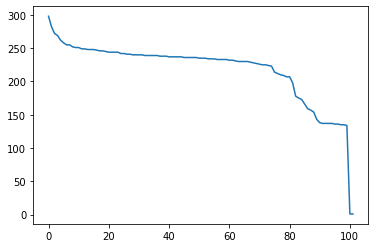

In [7]:
# Let's have a look to distribution 
l = list(Counter(list_label).values())
l.sort(reverse=True )
plt.plot( l )

In [8]:
def label_func(path_obj):
    return image_to_category[os.path.basename(path_obj)]

In [9]:
# default aug
aug = aug_transforms(mult=1.0, # Multiplication applying to `max_rotate`,`max_lighting`,`max_warp`
    do_flip=True, # Random flipping
    flip_vert=False, # Flip vertically
    max_rotate=10., # Maximum degree of rotation
    min_zoom=1., # Minimum zoom 
    max_zoom=1.1, # Maximum zoom 
    max_lighting=0.2, # Maximum scale of changing brightness 
    max_warp=0.2, # Maximum value of changing warp per
    p_affine=0.75, # Probability of applying affine transformation
    p_lighting=0.75, # Probability of changing brightnest and contrast 
    xtra_tfms=None, # Custom Transformations
    size=None, # Output size, duplicated if one value is specified
    mode='bilinear', # PyTorch `F.grid_sample` interpolation
    pad_mode=PadMode.Reflection, # A `PadMode`
    align_corners=True, # PyTorch `F.grid_sample` align_corners
    batch=False, # Apply identical transformation to entire batch
    min_scale=1.) # Minimum scale of the crop, in relation to image area)

In [10]:
aug = aug_transforms(
    mult=1.0, # Multiplication applying to `max_rotate`,`max_lighting`,`max_warp`
    do_flip=True, # Random flipping
    flip_vert=True, # Flip vertically
    max_rotate=20., # Maximum degree of rotation
    min_zoom=0.9, # Minimum zoom 
    max_zoom=1.2, # Maximum zoom 
    max_lighting=0.3, # Maximum scale of changing brightness 
    max_warp=0.2, # Maximum value of changing warp per
    p_affine=0.75, # Probability of applying affine transformation
    p_lighting=0.75, # Probability of changing brightnest and contrast 
    xtra_tfms=None, # Custom Transformations
    size=None, # Output size, duplicated if one value is specified
    mode='bilinear', # PyTorch `F.grid_sample` interpolation
    pad_mode=PadMode.Reflection, # A `PadMode`
    align_corners=True, # PyTorch `F.grid_sample` align_corners
    batch=False, # Apply identical transformation to entire batch
    min_scale=1.) # Minimum scale of the crop, in relation to image area)

In [11]:
if not assemble:
    dls = ImageDataLoaders.from_name_func(path, split_file, label_func, item_tfms=Resize(img_size),bs=bs,batch_tfms=aug, seed=42, valid_pct=0.2)

In [12]:
if not assemble:
    dls.show_batch(unique=True)

In [13]:
if not assemble:
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()

    if lr_find:
        learn.lr_find(suggest_funcs=(valley, slide))

    #default aug
    #14	2.132918	3.053929	0.719457	00:41

In [14]:
if not assemble:
    learn.fine_tune(epochs=num_epoch,
        base_lr=0.002,
        freeze_epochs=num_epoch_freeze)

In [15]:
#need it in both cases
tst_files = get_image_files("/home/remi/Documents/kaggle_data/test/").sorted()

if not assemble:
    tst_dl = dls.test_dl(tst_files)
    probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)

In [16]:
if not assemble:
    list_df =[] 
    list_cultivar =[] 

    for i in tqdm(range(len(tst_files))):#    len(tst_files)):
        list_df.append(os.path.basename(tst_files[i]))
        list_cultivar.append(dls.vocab[idxs[i]])

    import pandas as pd
    d = {'filename': list_df, 'cultivar': list_cultivar}
    df = pd.DataFrame(d)
    print(df)
    df.to_csv('submissionRemi_noTTA.csv', index=False)


In [17]:
!pwd

/home/remi/Documents/Sorghum_kaggle_circleCI


In [18]:
if not assemble:
    valid = learn.dls.valid
    preds,targs = learn.get_preds(dl=valid)
    error_rate(preds, targs)


In [19]:
if not assemble:
    tta_preds,_ = learn.tta(dl=valid, n=4, beta=0)#O.14 avec les paramètres par defaut 
    error_rate(tta_preds, targs)

In [20]:
if not assemble:
    preds,_ = learn.tta(dl=tst_dl)
    idxs = preds.argmax(dim=1)

In [21]:
if not assemble:
    list_df =[] 
    list_cultivar =[] 

    for i in tqdm(range(len(tst_files))):#    len(tst_files)):
        list_df.append(os.path.basename(tst_files[i]))
        list_cultivar.append(dls.vocab[idxs[i]])

    import pandas as pd
    d = {'filename': list_df, 'cultivar': list_cultivar}
    df = pd.DataFrame(d)
    df.to_csv('submissionRemiTTA.csv', index=False)
    df

In [22]:
if assemble: 
    def train(arch, size, accum=1,  epochs=12):
        item=Resize(size, method='squish')
        dls = ImageDataLoaders.from_name_func(path, split_file, label_func, item_tfms=item, bs=32//accum, batch_tfms=aug, valid_pct=0.2)
        cbs = GradientAccumulation(64) if accum else []
        learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
        #learn.fit_one_cycle(epochs)#
        learn.fine_tune(epochs, 0.01)

        return learn.tta(dl=dls.test_dl(tst_files))

In [23]:
#train('swin_large_patch4_window7_224', size = 224, epochs=1, accum=8)

In [24]:
#train('efficientnetv2_rw_m', size = 256, epochs=1, accum=2)

In [25]:
#train('convnext_large_in22k', size = 256, epochs=1, accum=8)


In [26]:
gc.collect()
torch.cuda.empty_cache()

In [27]:
epoch = 20
models = {
'convnext_large_in22k':{"size": 512, "epochs":epoch, "accum":8},
'resnet50':{"size": 512, "epochs":epoch, "accum":4},
    # 'resnet50':{"size": 1024, "epochs":epoch, "accum":11}
'convnext_large':{"size": 512, "epochs":epoch, "accum":8},

} 

In [28]:
tta_res = []

for arch,dict_arch in models.items():
    print('---',arch)
    print(dict_arch["size"]) 
    tta_res.append(train(arch, dict_arch["size"], epochs=dict_arch["epochs"] ,accum=dict_arch["accum"]))
    
    gc.collect()
    torch.cuda.empty_cache()

--- convnext_large_in22k
512


epoch,train_loss,valid_loss,error_rate,time
0,3.459795,2.364878,0.621902,59:46


epoch,train_loss,valid_loss,error_rate,time
0,2.063122,1.091385,0.284813,1:15:38
1,1.667837,0.799709,0.218792,1:15:49
2,1.474359,0.537174,0.150969,1:15:49
3,1.310725,0.409629,0.119874,1:15:48
4,1.145201,0.364107,0.108382,1:15:07
5,1.017722,0.293473,0.097566,1:15:50
6,0.887486,0.221820,0.070302,1:15:49
7,0.679399,0.170559,0.051600,1:15:48
8,0.731849,0.196245,0.064669,1:15:48
9,0.609400,0.148896,0.045516,1:15:47


--- resnet50
512


epoch,train_loss,valid_loss,error_rate,time
0,3.768729,2.859638,0.725552,08:02


epoch,train_loss,valid_loss,error_rate,time
0,3.006686,2.230973,0.594637,13:41
1,2.752154,2.030943,0.546643,13:40
2,2.608623,1.859402,0.513520,13:40
3,2.484942,1.791977,0.491663,13:40
4,2.349589,1.501876,0.425417,13:40
5,2.162051,1.360842,0.392744,13:40
6,1.961065,1.198153,0.342947,13:40
7,1.888011,1.113298,0.326273,13:40
8,1.660435,0.968228,0.282560,13:40
9,1.669290,0.929610,0.270167,13:40


--- convnext_large
512


epoch,train_loss,valid_loss,error_rate,time
0,3.859212,2.908853,0.734565,1:00:19


epoch,train_loss,valid_loss,error_rate,time
0,2.665104,1.693473,0.414151,1:15:39
1,2.111576,1.189454,0.305768,1:15:50
2,1.853035,0.852246,0.227805,1:15:51
3,1.664943,0.708666,0.196034,1:15:49
4,1.717070,0.617983,0.183191,1:15:51
5,1.378138,0.525070,0.151870,1:15:50
6,1.324074,0.403821,0.124380,1:15:49
7,1.103742,0.347368,0.102298,1:15:48
8,0.973001,0.273325,0.086525,1:15:48
9,0.888052,0.211912,0.064443,1:15:49


In [29]:
save_pickle(f'tta_res_imgSize{img_size}_probkeep{prob_keep}_.pkl', tta_res)


In [30]:
# convert tensor of prob to argument 
tta_res[-1][0].argmax(1).shape

dls = ImageDataLoaders.from_name_func(path, split_file, label_func, batch_tfms=aug, valid_pct=0.2)


In [31]:
len(tta_res)

3

In [50]:
names = list(models.keys())
del names[1] 
names.append("assemble")
names

['convnext_large_in22k', 'convnext_large', 'assemble']

In [51]:
tta_res2 = tta_res.copy()

In [52]:
#remove resnet50 prediction as it is not good
del tta_res2[1]

In [53]:
torch.stack([x[0] for x in  tta_res2],2)[:,:,:] .shape

torch.Size([23639, 100, 2])

In [54]:
names

['convnext_large_in22k', 'convnext_large', 'assemble']

In [55]:
if assemble:
    for model_idx in range(len(names)):
        if model_idx < len(names)-1:
           #regular model 
            idxs = [x.item() for x in list(tta_res[model_idx][0].argmax(1))] 
        else:
           #for this one we perform assembling 
            idxs = [x.item() for x in torch.stack([x[0] for x in  tta_res2],2).mean(-1).argmax(1)] 
            
        list_df =[] 
        list_cultivar =[] 

        for i in tqdm(range(len(tst_files))):#    len(tst_files)):
            list_df.append(os.path.basename(tst_files[i]))
            list_cultivar.append(dls.vocab[idxs[i]])

        d = {'filename': list_df, 'cultivar': list_cultivar}
        df = pd.DataFrame(d)
       # print(df)
        fn = f'submissionRemi_TTA_{names[model_idx]}_.csv'
        print(fn)
        df.to_csv(fn, index=False)

  0%|          | 0/23639 [00:00<?, ?it/s]

submissionRemi_TTA_convnext_large_in22k_.csv


  0%|          | 0/23639 [00:00<?, ?it/s]

submissionRemi_TTA_convnext_large_.csv


100%|██████████| 23639/23639 [00:01<00:00, 21994.76it/s]

submissionRemi_TTA_assemble_.csv
